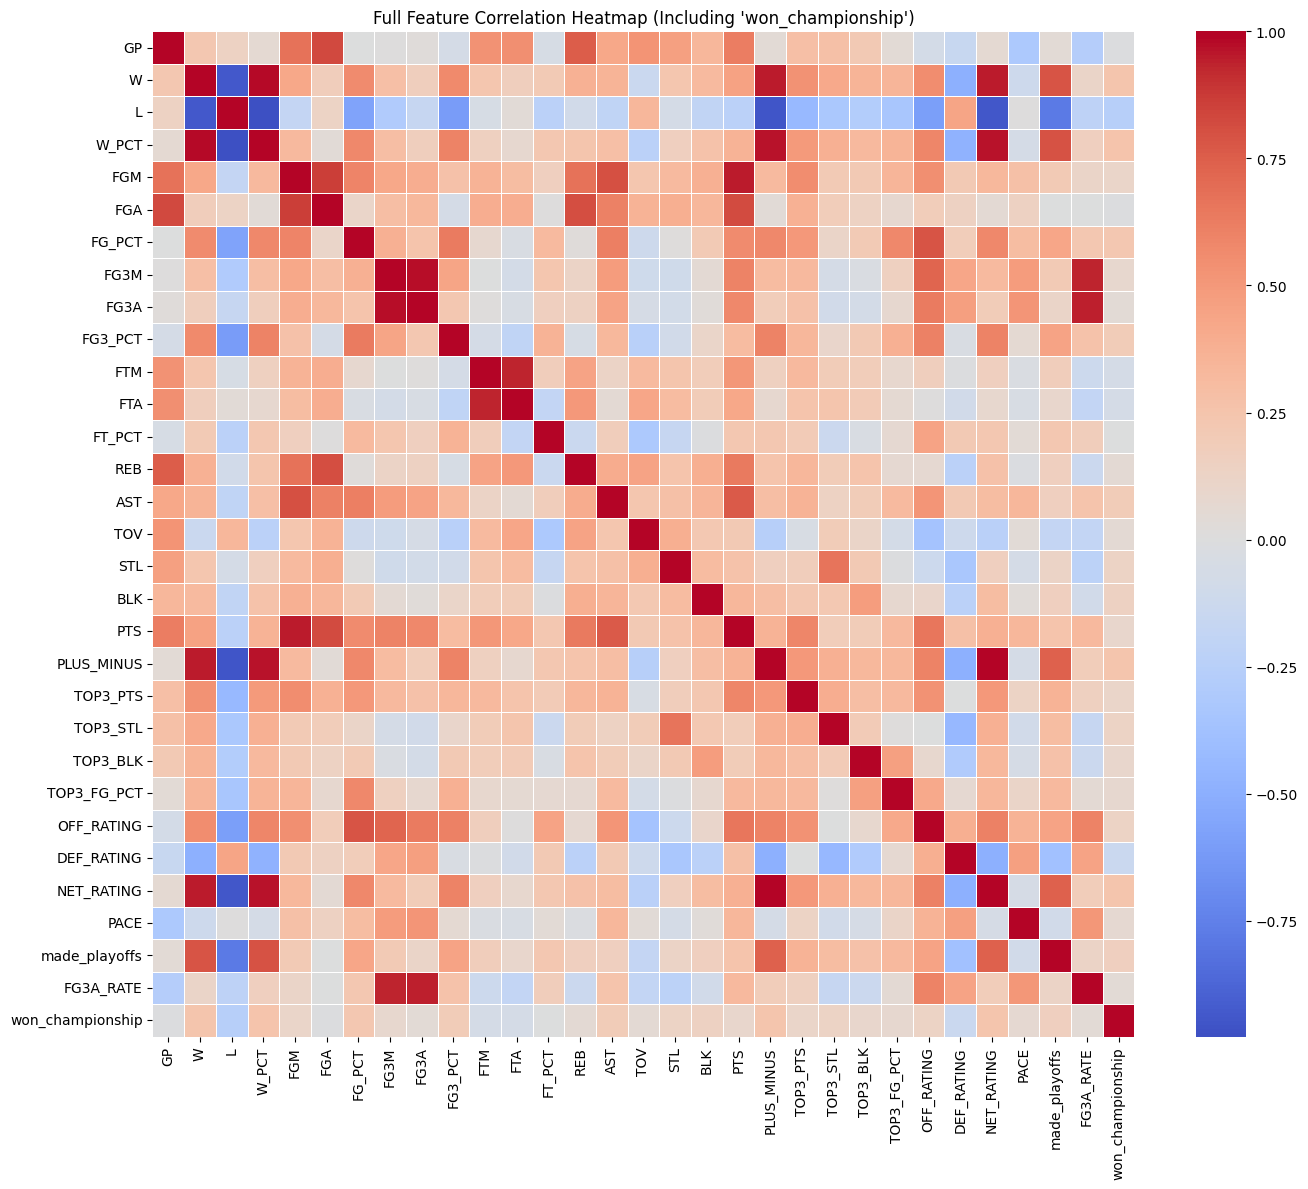

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("regular_season_with_championship.csv")

corr = df.corr(numeric_only=True)

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Full Feature Correlation Heatmap (Including 'won_championship')")
plt.tight_layout()
plt.show()

In [22]:
selected_features = [
    'FG_PCT',
    'FTM',
    'REB',
    'AST',
    'TOV',
    'STL',
    'BLK',
    'TOP3_PTS',
    'TOP3_STL',
    'TOP3_BLK',
    'OFF_RATING',
    'DEF_RATING',
    'PACE',
    'made_playoffs'
]

model_df = df[selected_features]

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

X = model_df.drop(columns='made_playoffs')
y = model_df['made_playoffs']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.86      0.81        28
           1       0.86      0.78      0.82        32

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



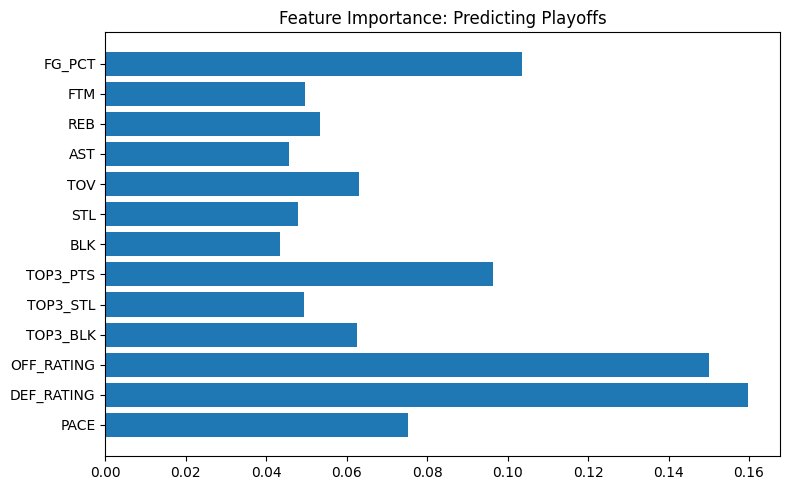

In [24]:
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.gca().invert_yaxis()
plt.title("Feature Importance: Predicting Playoffs")
plt.tight_layout()
plt.show()


            Did Not Make Playoffs  Made Playoffs  Difference
TOP3_PTS              1118.323810    1282.587500  164.263690
REB                   3471.192857    3545.893750   74.700893
AST                   1884.542857    1951.600000   67.057143
FTM                   1363.271429    1414.725000   51.453571
BLK                    376.892857     396.981250   20.088393
STL                    599.264286     617.481250   18.216964
TOP3_STL                68.297619      79.464583   11.166964
TOP3_BLK                37.269048      47.733333   10.464286
OFF_RATING             107.658571     111.621250    3.962679
FG_PCT                   0.454050       0.468225    0.014175
PACE                    98.776071      98.286000   -0.490071
DEF_RATING             111.411429     108.351250   -3.060179
TOV                   1145.321429    1106.775000  -38.546429


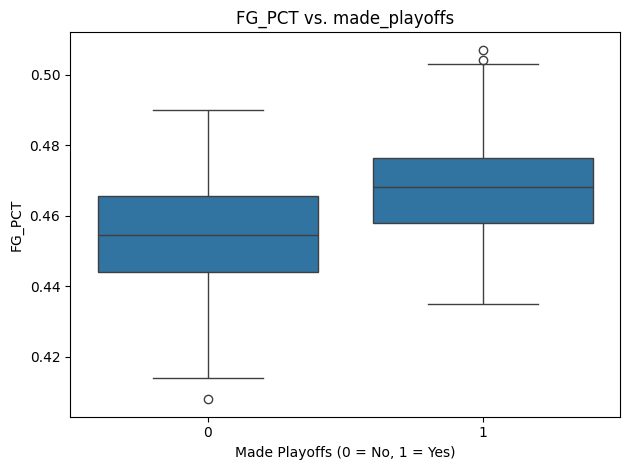

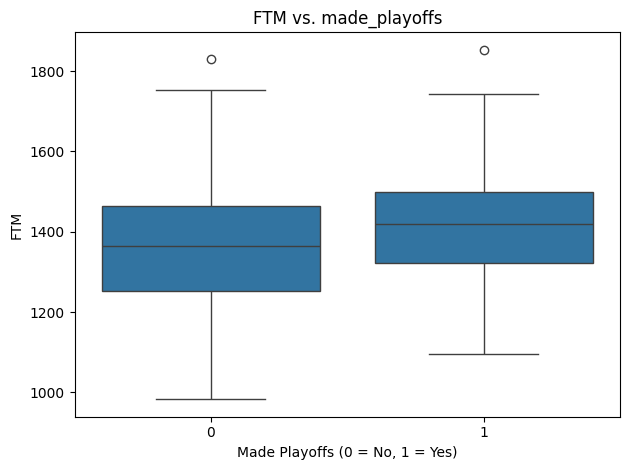

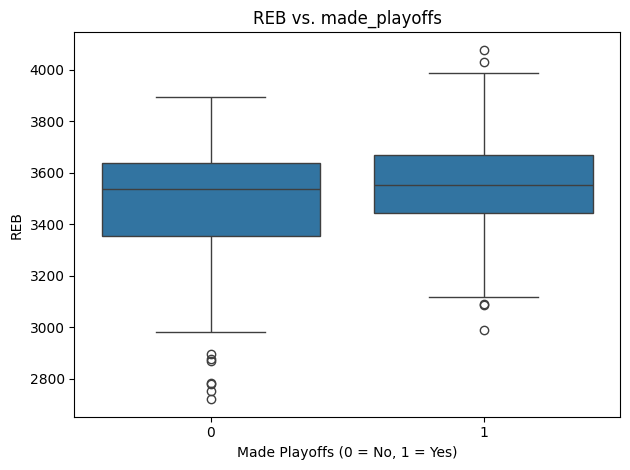

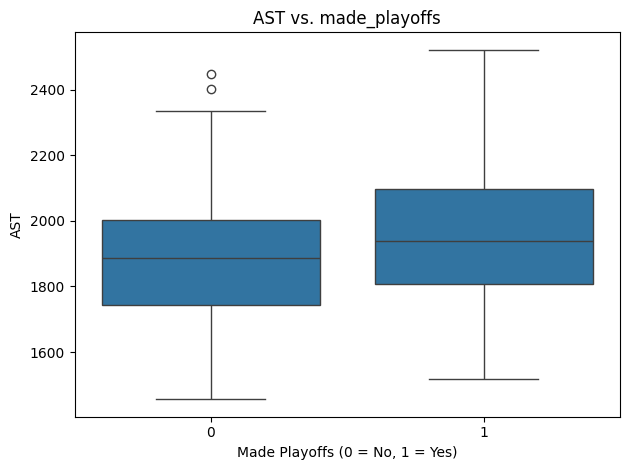

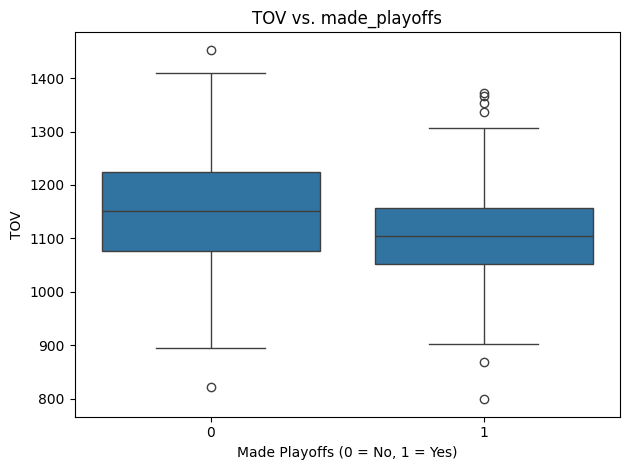

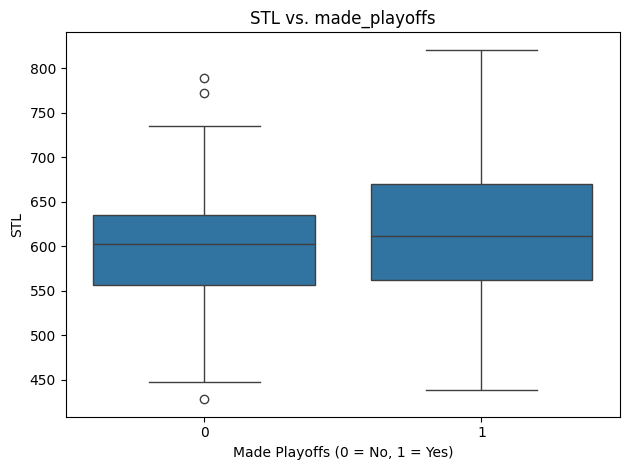

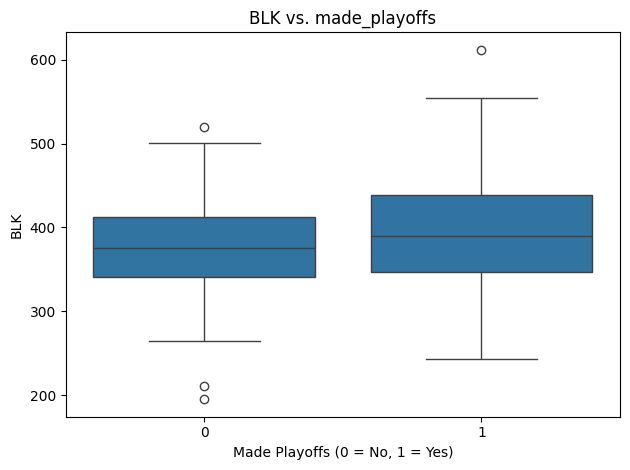

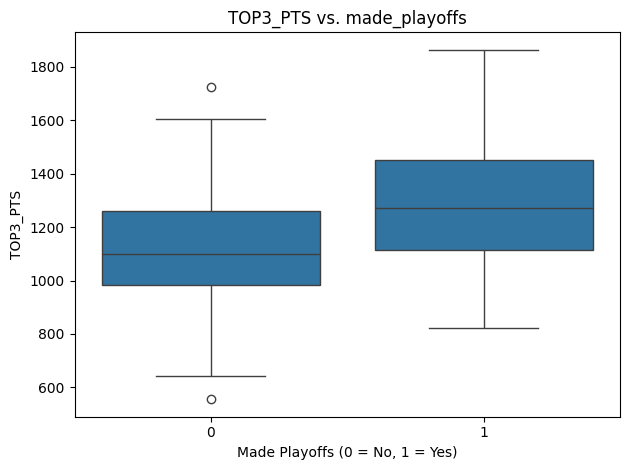

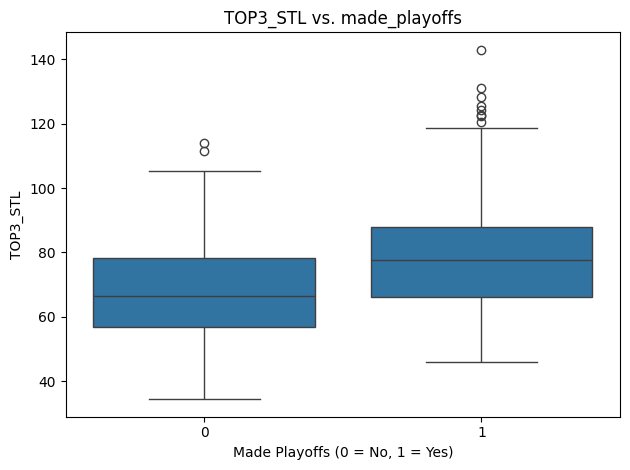

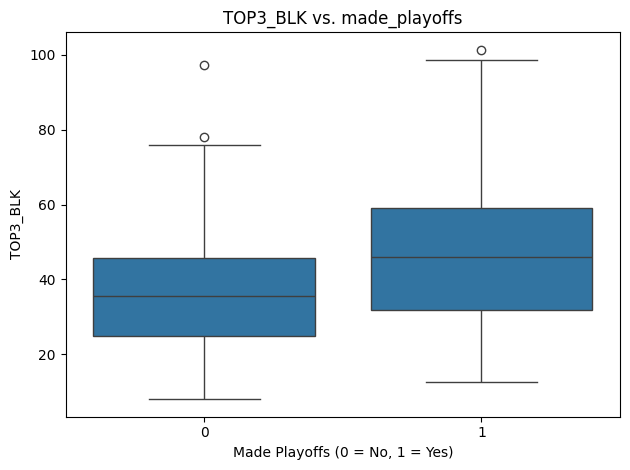

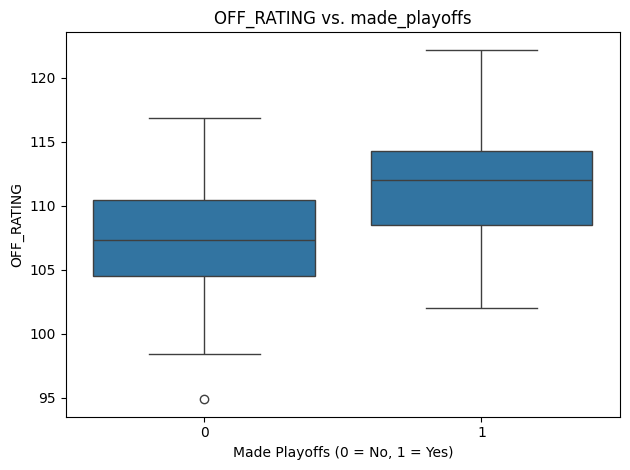

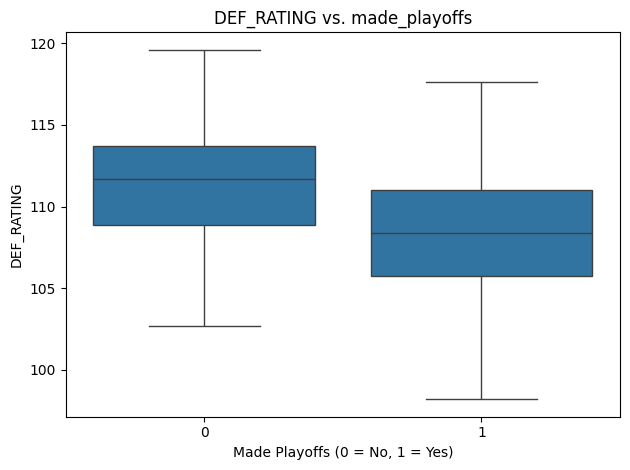

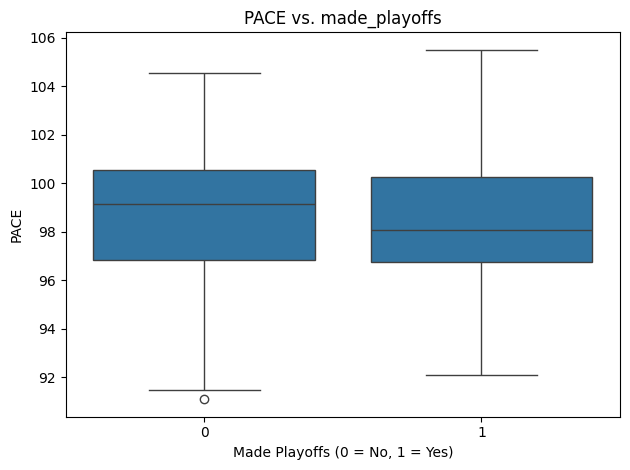


Point-Biserial Correlations with made_playoffs:

FG_PCT           r = 0.431,  p = 0.000
FTM              r = 0.173,  p = 0.003
REB              r = 0.160,  p = 0.005
AST              r = 0.159,  p = 0.006
TOV              r = -0.182,  p = 0.002
STL              r = 0.127,  p = 0.028
BLK              r = 0.160,  p = 0.005
TOP3_PTS         r = 0.364,  p = 0.000
TOP3_STL         r = 0.300,  p = 0.000
TOP3_BLK         r = 0.268,  p = 0.000
OFF_RATING       r = 0.445,  p = 0.000
DEF_RATING       r = -0.376,  p = 0.000
PACE             r = -0.091,  p = 0.115


In [25]:
from scipy.stats import pointbiserialr

df = pd.read_csv("regular_season_with_championship.csv")

features_for_playoffs = [
    'FG_PCT', 'FTM', 'REB', 'AST', 'TOV', 'STL', 'BLK',
    'TOP3_PTS', 'TOP3_STL', 'TOP3_BLK',
    'OFF_RATING', 'DEF_RATING', 'PACE'
]

mean_diff = df.groupby('made_playoffs')[features_for_playoffs].mean().T
mean_diff.columns = ['Did Not Make Playoffs', 'Made Playoffs']
mean_diff['Difference'] = mean_diff['Made Playoffs'] - mean_diff['Did Not Make Playoffs']
print(mean_diff.sort_values(by='Difference', ascending=False))

for col in features_for_playoffs:
    sns.boxplot(x='made_playoffs', y=col, data=df)
    plt.title(f"{col} vs. made_playoffs")
    plt.xlabel("Made Playoffs (0 = No, 1 = Yes)")
    plt.tight_layout()
    plt.show()

print("\nPoint-Biserial Correlations with made_playoffs:\n")
for col in features_for_playoffs:
    r, p = pointbiserialr(df['made_playoffs'], df[col])
    print(f"{col:<15}  r = {r:.3f},  p = {p:.3f}")


In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("regular_season_with_championship.csv")


features = [
    'FG_PCT', 'FTM', 'REB', 'AST', 'TOV', 'STL', 'BLK',
    'TOP3_PTS', 'TOP3_STL', 'TOP3_BLK',
    'OFF_RATING', 'DEF_RATING', 'PACE'
]

X = df[features]
y = df["W_PCT"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reg = LinearRegression()
reg.fit(X_scaled, y)

weights = pd.Series(reg.coef_, index=features)
df["team_score"] = reg.predict(X_scaled)

def compare_teams(teamA, teamB, season):
    teamA_score = df[(df["TEAM_NAME"] == teamA) & (df["SEASON"] == season)]["team_score"]
    teamB_score = df[(df["TEAM_NAME"] == teamB) & (df["SEASON"] == season)]["team_score"]

    if teamA_score.empty or teamB_score.empty:
        return f"One or both teams not found in {season}."
    
    a = teamA_score.values[0]
    b = teamB_score.values[0]
    prob_A_win = a / (a + b)

    return {
        "Team A": teamA,
        "Team B": teamB,
        "Season": season,
        f"Estimated win rate for {teamA}": f"{prob_A_win:.2%}"
    }


{'Team A': 'Golden State Warriors',
 'Team B': 'Boston Celtics',
 'Season': '2014-15',
 'Golden State Warriors score': np.float64(0.7993353331217872),
 'Boston Celtics score': np.float64(0.5095438353785726),
 'Estimated win rate for Golden State Warriors': '61.07%'}

In [ ]:
compare_result = compare_teams("Golden State Warriors", "Boston Celtics", "2014-15")
compare_result

R² (Train): 0.9325
R² (Test):  0.9208
MAE:        0.0345
MSE:        0.0019


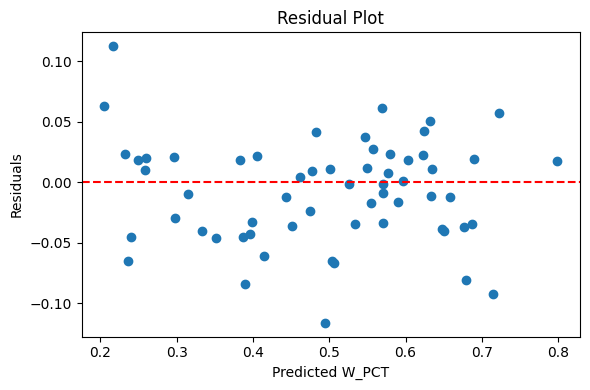

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("regular_season_with_championship.csv")

# Define features and target
features = [
    'FG_PCT', 'FTM', 'REB', 'AST', 'TOV', 'STL', 'BLK',
    'TOP3_PTS', 'TOP3_STL', 'TOP3_BLK',
    'OFF_RATING', 'DEF_RATING', 'PACE'
]
X = df[features]
y = df['W_PCT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

r2_train = reg.score(X_train, y_train)
r2_test = reg.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² (Train): {r2_train:.4f}")
print(f"R² (Test):  {r2_test:.4f}")
print(f"MAE:        {mae:.4f}")
print(f"MSE:        {mse:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted W_PCT")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


   Actual W_PCT  Predicted W_PCT
0         0.708            0.689
1         0.268            0.205
2         0.486            0.477
3         0.817            0.799
4         0.780            0.723
5         0.622            0.604
6         0.639            0.676
7         0.354            0.397
8         0.646            0.658
9         0.431            0.443


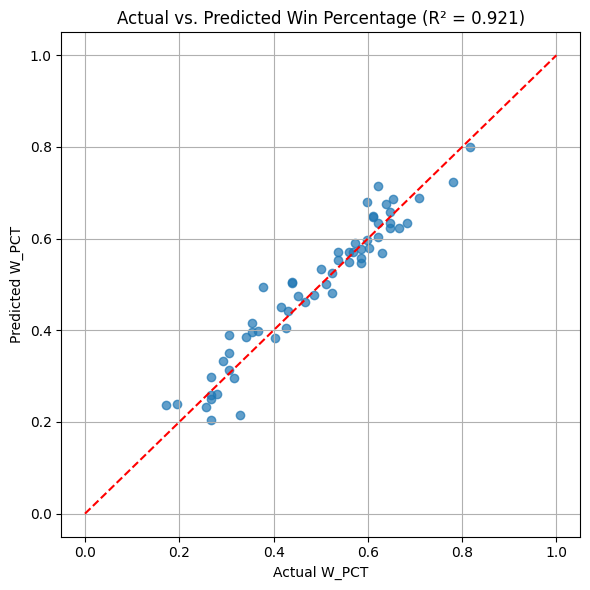

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

results_df = pd.DataFrame({
    'Actual W_PCT': y_test.values,
    'Predicted W_PCT': y_pred
})

results_df = results_df.round(3)

print(results_df.head(10))

plt.figure(figsize=(6, 6))
plt.scatter(results_df['Actual W_PCT'], results_df['Predicted W_PCT'], alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel("Actual W_PCT")
plt.ylabel("Predicted W_PCT")
plt.title(f"Actual vs. Predicted Win Percentage (R² = {r2_score(y_test, y_pred):.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()
